In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = True

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-20 10:51:06,495 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-02-20 10:51:06,499 model.configuration INFO Model run started at 2018-02-20 10:51:06.483751
2018-02-20 10:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-20 10:51:06.483248



2018-02-20 10:51:07,025 model.meteo INFO No forcing downscaling is implemented.
2018-02-20 10:51:07,179 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-20 10:51:07,180 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-20 10:51:07,181 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-20 10:51:07,182 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-20 10:51:07,182 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-20 10:51:07,188 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-20 10:51:07,188 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-20 10:51:09,558 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-02-20 10:51:17,579 model.meteo INFO No forcing downscaling is implemented.
2018-02-20 10:51:17,727 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-20 10:51:17,731 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-20 10:51:17,732 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-20 10:51:17,732 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-20 10:51:17,733 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-20 10:51:17,739 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-20 10:51:17,740 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-20 10:51:20,106 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-02-20 10:51:32,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-20 10:51:32,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-20 10:51:32,284 model.groundwater INFO Updating groundwater
2018-02-20 10:51:32,290 model.routing INFO routing in progress
2018-02-20 10:51:32,293 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:32,304 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:32,323 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:32,340 model.routing INFO sub-daily t

2018-02-20 10:51:34,714 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-20 10:51:34,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-20 10:51:34,922 model.groundwater INFO Updating groundwater
2018-02-20 10:51:34,929 model.routing INFO routing in progress
2018-02-20 10:51:34,932 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:34,944 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:34,963 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:34,982 model.routing INFO sub-daily t

2018-02-20 10:51:37,526 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-20 10:51:37,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-20 10:51:37,737 model.groundwater INFO Updating groundwater
2018-02-20 10:51:37,746 model.routing INFO routing in progress
2018-02-20 10:51:37,751 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:37,764 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:37,784 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:37,805 model.routing INFO sub-daily t

2018-02-20 10:51:40,348 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-20 10:51:40,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-20 10:51:40,573 model.groundwater INFO Updating groundwater
2018-02-20 10:51:40,579 model.routing INFO routing in progress
2018-02-20 10:51:40,583 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:40,594 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:40,612 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:40,630 model.routing INFO sub-daily t

2018-02-20 10:51:43,106 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 10:51:43,191 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 10:51:43,343 model.groundwater INFO Updating groundwater
2018-02-20 10:51:43,350 model.routing INFO routing in progress
2018-02-20 10:51:43,354 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:43,366 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:43,385 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:43,403 model.routing INFO sub-daily

2018-02-20 10:51:45,902 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-20 10:51:45,982 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-20 10:51:46,114 model.groundwater INFO Updating groundwater
2018-02-20 10:51:46,119 model.routing INFO routing in progress
2018-02-20 10:51:46,122 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:46,133 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:46,151 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:46,169 model.routing INFO sub-daily

2018-02-20 10:51:48,666 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-20 10:51:48,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-20 10:51:48,854 model.groundwater INFO Updating groundwater
2018-02-20 10:51:48,860 model.routing INFO routing in progress
2018-02-20 10:51:48,864 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:48,875 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:48,895 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:48,914 model.routing INFO sub-daily

2018-02-20 10:51:51,500 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-20 10:51:51,579 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-20 10:51:51,725 model.groundwater INFO Updating groundwater
2018-02-20 10:51:51,731 model.routing INFO routing in progress
2018-02-20 10:51:51,734 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:51,745 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:51,763 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:51,782 model.routing INFO sub-daily

2018-02-20 10:51:54,204 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-20 10:51:54,292 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-20 10:51:54,436 model.groundwater INFO Updating groundwater
2018-02-20 10:51:54,444 model.routing INFO routing in progress
2018-02-20 10:51:54,451 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:54,464 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:54,484 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:54,505 model.routing INFO sub-daily

2018-02-20 10:51:57,104 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-20 10:51:57,181 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-20 10:51:57,317 model.groundwater INFO Updating groundwater
2018-02-20 10:51:57,322 model.routing INFO routing in progress
2018-02-20 10:51:57,326 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:51:57,336 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:51:57,356 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:51:57,375 model.routing INFO sub-daily

2018-02-20 10:51:59,839 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-20 10:51:59,930 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-20 10:52:00,109 model.groundwater INFO Updating groundwater
2018-02-20 10:52:00,115 model.routing INFO routing in progress
2018-02-20 10:52:00,121 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:00,133 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:00,156 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:00,175 model.routing INFO sub-daily

2018-02-20 10:52:02,712 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-20 10:52:02,794 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-20 10:52:02,937 model.groundwater INFO Updating groundwater
2018-02-20 10:52:02,945 model.routing INFO routing in progress
2018-02-20 10:52:02,949 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:02,960 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:02,979 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:02,999 model.routing INFO sub-daily

2018-02-20 10:52:05,444 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-20 10:52:05,530 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-20 10:52:05,678 model.groundwater INFO Updating groundwater
2018-02-20 10:52:05,684 model.routing INFO routing in progress
2018-02-20 10:52:05,687 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:05,698 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:05,716 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:05,734 model.routing INFO sub-daily

2018-02-20 10:52:08,150 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-20 10:52:08,232 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-20 10:52:08,369 model.groundwater INFO Updating groundwater
2018-02-20 10:52:08,380 model.routing INFO routing in progress
2018-02-20 10:52:08,387 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:08,400 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:08,420 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:08,440 model.routing INFO sub-daily

2018-02-20 10:52:10,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-20 10:52:11,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-20 10:52:11,170 model.groundwater INFO Updating groundwater
2018-02-20 10:52:11,176 model.routing INFO routing in progress
2018-02-20 10:52:11,179 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:11,190 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:11,212 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:11,230 model.routing INFO sub-daily

2018-02-20 10:52:13,638 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-20 10:52:13,716 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-20 10:52:13,853 model.groundwater INFO Updating groundwater
2018-02-20 10:52:13,860 model.routing INFO routing in progress
2018-02-20 10:52:13,866 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:13,880 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:13,980 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:14,082 model.routing INFO sub-daily t

2018-02-20 10:52:18,301 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-20 10:52:18,397 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-20 10:52:18,531 model.groundwater INFO Updating groundwater
2018-02-20 10:52:18,537 model.routing INFO routing in progress
2018-02-20 10:52:18,541 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:18,552 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:18,569 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:18,587 model.routing INFO sub-daily t

2018-02-20 10:52:20,952 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-20 10:52:21,036 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-20 10:52:21,172 model.groundwater INFO Updating groundwater
2018-02-20 10:52:21,178 model.routing INFO routing in progress
2018-02-20 10:52:21,182 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:21,193 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:21,211 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:21,230 model.routing INFO sub-daily t

2018-02-20 10:52:23,716 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-20 10:52:23,809 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-20 10:52:23,959 model.groundwater INFO Updating groundwater
2018-02-20 10:52:23,967 model.routing INFO routing in progress
2018-02-20 10:52:23,971 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:23,989 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:24,007 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:24,025 model.routing INFO sub-daily t

2018-02-20 10:52:26,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-20 10:52:26,624 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-20 10:52:26,770 model.groundwater INFO Updating groundwater
2018-02-20 10:52:26,776 model.routing INFO routing in progress
2018-02-20 10:52:26,779 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:26,791 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:26,809 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:26,828 model.routing INFO sub-daily t

2018-02-20 10:52:29,293 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-20 10:52:29,377 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-20 10:52:29,521 model.groundwater INFO Updating groundwater
2018-02-20 10:52:29,528 model.routing INFO routing in progress
2018-02-20 10:52:29,531 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:29,542 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:29,561 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:29,581 model.routing INFO sub-daily

2018-02-20 10:52:32,120 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-20 10:52:32,199 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-20 10:52:32,335 model.groundwater INFO Updating groundwater
2018-02-20 10:52:32,340 model.routing INFO routing in progress
2018-02-20 10:52:32,343 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:32,354 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:32,372 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:32,389 model.routing INFO sub-daily

2018-02-20 10:52:34,883 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-20 10:52:34,962 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-20 10:52:35,097 model.groundwater INFO Updating groundwater
2018-02-20 10:52:35,103 model.routing INFO routing in progress
2018-02-20 10:52:35,107 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:35,119 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:35,137 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:35,155 model.routing INFO sub-daily

2018-02-20 10:52:37,507 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-20 10:52:37,606 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-20 10:52:37,759 model.groundwater INFO Updating groundwater
2018-02-20 10:52:37,769 model.routing INFO routing in progress
2018-02-20 10:52:37,776 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:37,789 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:37,810 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:37,829 model.routing INFO sub-daily

2018-02-20 10:52:40,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-20 10:52:40,371 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-20 10:52:40,508 model.groundwater INFO Updating groundwater
2018-02-20 10:52:40,515 model.routing INFO routing in progress
2018-02-20 10:52:40,521 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:40,534 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:40,555 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:40,575 model.routing INFO sub-daily

2018-02-20 10:52:43,087 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-20 10:52:43,167 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-20 10:52:43,301 model.groundwater INFO Updating groundwater
2018-02-20 10:52:43,307 model.routing INFO routing in progress
2018-02-20 10:52:43,313 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:43,324 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:43,343 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:43,361 model.routing INFO sub-daily

2018-02-20 10:52:45,768 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-20 10:52:45,848 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-20 10:52:45,985 model.groundwater INFO Updating groundwater
2018-02-20 10:52:45,993 model.routing INFO routing in progress
2018-02-20 10:52:45,998 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:46,012 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:46,033 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:46,051 model.routing INFO sub-daily

2018-02-20 10:52:48,564 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-20 10:52:48,648 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-20 10:52:48,796 model.groundwater INFO Updating groundwater
2018-02-20 10:52:48,804 model.routing INFO routing in progress
2018-02-20 10:52:48,811 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:48,825 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:48,845 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:48,866 model.routing INFO sub-daily

2018-02-20 10:52:51,352 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-20 10:52:51,434 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-20 10:52:51,576 model.groundwater INFO Updating groundwater
2018-02-20 10:52:51,584 model.routing INFO routing in progress
2018-02-20 10:52:51,590 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:51,603 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:51,621 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:51,640 model.routing INFO sub-daily

2018-02-20 10:52:54,112 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-20 10:52:54,199 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-20 10:52:54,345 model.groundwater INFO Updating groundwater
2018-02-20 10:52:54,351 model.routing INFO routing in progress
2018-02-20 10:52:54,354 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:54,363 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:54,377 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:54,392 model.routing INFO sub-daily

2018-02-20 10:52:58,948 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-20 10:52:59,031 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-20 10:52:59,169 model.groundwater INFO Updating groundwater
2018-02-20 10:52:59,176 model.routing INFO routing in progress
2018-02-20 10:52:59,182 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:52:59,193 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:52:59,225 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:52:59,245 model.routing INFO sub-daily t

2018-02-20 10:53:01,773 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-20 10:53:01,852 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-20 10:53:01,992 model.groundwater INFO Updating groundwater
2018-02-20 10:53:01,999 model.routing INFO routing in progress
2018-02-20 10:53:02,002 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:02,014 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:02,032 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:02,053 model.routing INFO sub-daily t

2018-02-20 10:53:04,658 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-20 10:53:04,741 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-20 10:53:04,881 model.groundwater INFO Updating groundwater
2018-02-20 10:53:04,887 model.routing INFO routing in progress
2018-02-20 10:53:04,890 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:04,901 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:04,920 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:04,938 model.routing INFO sub-daily t

2018-02-20 10:53:07,500 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-20 10:53:07,582 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-20 10:53:07,749 model.groundwater INFO Updating groundwater
2018-02-20 10:53:07,758 model.routing INFO routing in progress
2018-02-20 10:53:07,764 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:07,777 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:07,798 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:07,821 model.routing INFO sub-daily t

2018-02-20 10:53:10,325 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-20 10:53:10,408 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-20 10:53:10,538 model.groundwater INFO Updating groundwater
2018-02-20 10:53:10,544 model.routing INFO routing in progress
2018-02-20 10:53:10,547 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:10,557 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:10,575 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:10,593 model.routing INFO sub-daily

2018-02-20 10:53:13,143 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-20 10:53:13,224 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-20 10:53:13,359 model.groundwater INFO Updating groundwater
2018-02-20 10:53:13,365 model.routing INFO routing in progress
2018-02-20 10:53:13,379 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:13,392 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:13,411 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:13,430 model.routing INFO sub-daily

2018-02-20 10:53:16,013 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-20 10:53:16,090 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-20 10:53:16,238 model.groundwater INFO Updating groundwater
2018-02-20 10:53:16,243 model.routing INFO routing in progress
2018-02-20 10:53:16,247 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:16,258 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:16,277 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:16,296 model.routing INFO sub-daily

2018-02-20 10:53:18,789 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-20 10:53:18,876 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-20 10:53:19,025 model.groundwater INFO Updating groundwater
2018-02-20 10:53:19,031 model.routing INFO routing in progress
2018-02-20 10:53:19,045 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:19,059 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:19,080 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:19,099 model.routing INFO sub-daily

2018-02-20 10:53:21,597 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-20 10:53:21,684 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-20 10:53:21,832 model.groundwater INFO Updating groundwater
2018-02-20 10:53:21,839 model.routing INFO routing in progress
2018-02-20 10:53:21,843 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:21,855 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:21,876 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:21,897 model.routing INFO sub-daily

2018-02-20 10:53:24,347 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-20 10:53:24,430 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-20 10:53:24,573 model.groundwater INFO Updating groundwater
2018-02-20 10:53:24,579 model.routing INFO routing in progress
2018-02-20 10:53:24,583 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:24,594 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:24,613 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:24,633 model.routing INFO sub-daily

2018-02-20 10:53:27,049 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-20 10:53:27,129 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-20 10:53:27,269 model.groundwater INFO Updating groundwater
2018-02-20 10:53:27,276 model.routing INFO routing in progress
2018-02-20 10:53:27,281 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:27,293 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:27,311 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:27,331 model.routing INFO sub-daily

2018-02-20 10:53:29,726 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-20 10:53:29,804 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-20 10:53:29,938 model.groundwater INFO Updating groundwater
2018-02-20 10:53:29,946 model.routing INFO routing in progress
2018-02-20 10:53:29,949 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:29,960 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:29,978 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:30,000 model.routing INFO sub-daily

2018-02-20 10:53:32,379 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-20 10:53:32,464 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-20 10:53:32,593 model.groundwater INFO Updating groundwater
2018-02-20 10:53:32,599 model.routing INFO routing in progress
2018-02-20 10:53:32,603 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:32,614 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:32,632 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:32,650 model.routing INFO sub-daily

2018-02-20 10:53:34,952 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-20 10:53:35,034 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-20 10:53:35,176 model.groundwater INFO Updating groundwater
2018-02-20 10:53:35,185 model.routing INFO routing in progress
2018-02-20 10:53:35,191 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:35,204 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:35,223 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:35,243 model.routing INFO sub-daily

2018-02-20 10:53:37,632 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-20 10:53:37,713 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-20 10:53:37,840 model.groundwater INFO Updating groundwater
2018-02-20 10:53:37,845 model.routing INFO routing in progress
2018-02-20 10:53:37,849 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:37,859 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:37,877 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:37,895 model.routing INFO sub-daily

2018-02-20 10:53:40,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-20 10:53:40,367 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-20 10:53:40,509 model.groundwater INFO Updating groundwater
2018-02-20 10:53:40,519 model.routing INFO routing in progress
2018-02-20 10:53:40,536 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:40,562 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:40,672 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:40,783 model.routing INFO sub-daily t

2018-02-20 10:53:45,024 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-20 10:53:45,103 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-20 10:53:45,238 model.groundwater INFO Updating groundwater
2018-02-20 10:53:45,246 model.routing INFO routing in progress
2018-02-20 10:53:45,251 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:45,265 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:45,285 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:45,305 model.routing INFO sub-daily t

2018-02-20 10:53:47,805 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-20 10:53:47,898 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-20 10:53:48,036 model.groundwater INFO Updating groundwater
2018-02-20 10:53:48,041 model.routing INFO routing in progress
2018-02-20 10:53:48,045 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:48,064 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:48,084 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:48,103 model.routing INFO sub-daily t

2018-02-20 10:53:50,449 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-20 10:53:50,544 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-20 10:53:50,692 model.groundwater INFO Updating groundwater
2018-02-20 10:53:50,699 model.routing INFO routing in progress
2018-02-20 10:53:50,703 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:50,716 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:50,736 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:50,756 model.routing INFO sub-daily t

2018-02-20 10:53:53,344 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-20 10:53:53,430 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-20 10:53:53,560 model.groundwater INFO Updating groundwater
2018-02-20 10:53:53,566 model.routing INFO routing in progress
2018-02-20 10:53:53,570 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:53,580 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:53,599 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:53,620 model.routing INFO sub-daily t

2018-02-20 10:53:56,050 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-20 10:53:56,130 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-20 10:53:56,265 model.groundwater INFO Updating groundwater
2018-02-20 10:53:56,270 model.routing INFO routing in progress
2018-02-20 10:53:56,277 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:56,289 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:56,308 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:56,327 model.routing INFO sub-daily

2018-02-20 10:53:58,768 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-20 10:53:58,845 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-20 10:53:58,981 model.groundwater INFO Updating groundwater
2018-02-20 10:53:58,991 model.routing INFO routing in progress
2018-02-20 10:53:58,996 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:53:59,008 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:53:59,028 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:53:59,053 model.routing INFO sub-daily

2018-02-20 10:54:01,492 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-20 10:54:01,575 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-20 10:54:01,715 model.groundwater INFO Updating groundwater
2018-02-20 10:54:01,721 model.routing INFO routing in progress
2018-02-20 10:54:01,725 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:01,734 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:01,750 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:01,769 model.routing INFO sub-daily

2018-02-20 10:54:04,223 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-20 10:54:04,309 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-20 10:54:04,447 model.groundwater INFO Updating groundwater
2018-02-20 10:54:04,456 model.routing INFO routing in progress
2018-02-20 10:54:04,461 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:04,474 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:04,495 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:04,517 model.routing INFO sub-daily

2018-02-20 10:54:06,980 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-20 10:54:07,073 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-20 10:54:07,225 model.groundwater INFO Updating groundwater
2018-02-20 10:54:07,235 model.routing INFO routing in progress
2018-02-20 10:54:07,240 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:07,253 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:07,277 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:07,299 model.routing INFO sub-daily

2018-02-20 10:54:09,770 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-20 10:54:09,855 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-20 10:54:09,993 model.groundwater INFO Updating groundwater
2018-02-20 10:54:09,999 model.routing INFO routing in progress
2018-02-20 10:54:10,003 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:10,013 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:10,031 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:10,049 model.routing INFO sub-daily

2018-02-20 10:54:12,453 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-20 10:54:12,534 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-20 10:54:12,671 model.groundwater INFO Updating groundwater
2018-02-20 10:54:12,677 model.routing INFO routing in progress
2018-02-20 10:54:12,680 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:12,691 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:12,710 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:12,729 model.routing INFO sub-daily

2018-02-20 10:54:15,151 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-20 10:54:15,231 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-20 10:54:15,368 model.groundwater INFO Updating groundwater
2018-02-20 10:54:15,376 model.routing INFO routing in progress
2018-02-20 10:54:15,380 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:15,391 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:15,410 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:15,429 model.routing INFO sub-daily

2018-02-20 10:54:17,824 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-20 10:54:17,904 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-20 10:54:18,039 model.groundwater INFO Updating groundwater
2018-02-20 10:54:18,046 model.routing INFO routing in progress
2018-02-20 10:54:18,051 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:18,064 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:18,084 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:18,103 model.routing INFO sub-daily

2018-02-20 10:54:20,559 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-20 10:54:20,643 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-20 10:54:20,783 model.groundwater INFO Updating groundwater
2018-02-20 10:54:20,791 model.routing INFO routing in progress
2018-02-20 10:54:20,796 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:20,808 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:20,829 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:20,848 model.routing INFO sub-daily

2018-02-20 10:54:23,276 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-20 10:54:23,369 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-20 10:54:23,530 model.groundwater INFO Updating groundwater
2018-02-20 10:54:23,548 model.routing INFO routing in progress
2018-02-20 10:54:23,553 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:23,567 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:23,678 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:23,789 model.routing INFO sub-daily t

2018-02-20 10:54:27,972 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-20 10:54:28,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-20 10:54:28,189 model.groundwater INFO Updating groundwater
2018-02-20 10:54:28,195 model.routing INFO routing in progress
2018-02-20 10:54:28,198 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:28,209 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:28,230 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:28,247 model.routing INFO sub-daily t

2018-02-20 10:54:30,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-20 10:54:30,806 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-20 10:54:30,943 model.groundwater INFO Updating groundwater
2018-02-20 10:54:30,949 model.routing INFO routing in progress
2018-02-20 10:54:30,952 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:30,963 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:30,980 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:30,998 model.routing INFO sub-daily t

2018-02-20 10:54:33,467 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-20 10:54:33,539 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-20 10:54:33,670 model.groundwater INFO Updating groundwater
2018-02-20 10:54:33,677 model.routing INFO routing in progress
2018-02-20 10:54:33,683 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:33,695 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:33,713 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:33,731 model.routing INFO sub-daily t

2018-02-20 10:54:36,120 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-20 10:54:36,203 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-20 10:54:36,342 model.groundwater INFO Updating groundwater
2018-02-20 10:54:36,347 model.routing INFO routing in progress
2018-02-20 10:54:36,350 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:36,360 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:36,378 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:36,395 model.routing INFO sub-daily t

2018-02-20 10:54:38,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-20 10:54:38,977 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-20 10:54:39,112 model.groundwater INFO Updating groundwater
2018-02-20 10:54:39,117 model.routing INFO routing in progress
2018-02-20 10:54:39,121 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:39,131 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:39,149 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:39,167 model.routing INFO sub-daily

2018-02-20 10:54:41,614 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-20 10:54:41,695 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-20 10:54:41,830 model.groundwater INFO Updating groundwater
2018-02-20 10:54:41,838 model.routing INFO routing in progress
2018-02-20 10:54:41,841 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:41,854 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:41,872 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:41,891 model.routing INFO sub-daily

2018-02-20 10:54:44,265 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-20 10:54:44,354 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-20 10:54:44,509 model.groundwater INFO Updating groundwater
2018-02-20 10:54:44,515 model.routing INFO routing in progress
2018-02-20 10:54:44,519 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:44,531 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:44,551 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:44,570 model.routing INFO sub-daily

2018-02-20 10:54:47,079 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-20 10:54:47,159 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-20 10:54:47,297 model.groundwater INFO Updating groundwater
2018-02-20 10:54:47,304 model.routing INFO routing in progress
2018-02-20 10:54:47,307 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:47,318 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:47,336 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:47,355 model.routing INFO sub-daily

2018-02-20 10:54:49,834 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-20 10:54:49,917 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-20 10:54:50,064 model.groundwater INFO Updating groundwater
2018-02-20 10:54:50,070 model.routing INFO routing in progress
2018-02-20 10:54:50,074 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:50,087 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:50,107 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:50,129 model.routing INFO sub-daily

2018-02-20 10:54:52,541 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-20 10:54:52,622 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-20 10:54:52,756 model.groundwater INFO Updating groundwater
2018-02-20 10:54:52,763 model.routing INFO routing in progress
2018-02-20 10:54:52,774 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:52,785 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:52,805 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:52,823 model.routing INFO sub-daily

2018-02-20 10:54:55,093 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-20 10:54:55,170 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-20 10:54:55,303 model.groundwater INFO Updating groundwater
2018-02-20 10:54:55,309 model.routing INFO routing in progress
2018-02-20 10:54:55,314 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:55,326 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:55,346 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:55,365 model.routing INFO sub-daily

2018-02-20 10:54:57,770 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-20 10:54:57,859 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-20 10:54:58,006 model.groundwater INFO Updating groundwater
2018-02-20 10:54:58,012 model.routing INFO routing in progress
2018-02-20 10:54:58,016 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:54:58,028 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:54:58,046 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:54:58,063 model.routing INFO sub-daily

2018-02-20 10:55:00,480 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-20 10:55:00,569 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-20 10:55:00,707 model.groundwater INFO Updating groundwater
2018-02-20 10:55:00,712 model.routing INFO routing in progress
2018-02-20 10:55:00,715 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:00,725 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:00,744 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:00,761 model.routing INFO sub-daily

2018-02-20 10:55:03,220 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-20 10:55:03,303 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-20 10:55:03,441 model.groundwater INFO Updating groundwater
2018-02-20 10:55:03,449 model.routing INFO routing in progress
2018-02-20 10:55:03,454 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:03,467 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:03,487 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:03,506 model.routing INFO sub-daily

2018-02-20 10:55:06,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-20 10:55:06,152 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-20 10:55:06,259 model.groundwater INFO Updating groundwater
2018-02-20 10:55:06,265 model.routing INFO routing in progress
2018-02-20 10:55:06,268 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:06,282 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:06,300 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:06,319 model.routing INFO sub-daily

2018-02-20 10:55:10,593 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-20 10:55:10,659 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-20 10:55:10,763 model.groundwater INFO Updating groundwater
2018-02-20 10:55:10,767 model.routing INFO routing in progress
2018-02-20 10:55:10,771 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:10,779 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:10,796 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:10,811 model.routing INFO sub-daily t

2018-02-20 10:55:13,219 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-20 10:55:13,310 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-20 10:55:13,450 model.groundwater INFO Updating groundwater
2018-02-20 10:55:13,456 model.routing INFO routing in progress
2018-02-20 10:55:13,459 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:13,471 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:13,490 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:13,508 model.routing INFO sub-daily t

2018-02-20 10:55:15,898 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-20 10:55:15,979 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-20 10:55:16,120 model.groundwater INFO Updating groundwater
2018-02-20 10:55:16,129 model.routing INFO routing in progress
2018-02-20 10:55:16,134 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:16,147 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:16,178 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:16,203 model.routing INFO sub-daily t

2018-02-20 10:55:18,703 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-20 10:55:18,789 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-20 10:55:18,937 model.groundwater INFO Updating groundwater
2018-02-20 10:55:18,948 model.routing INFO routing in progress
2018-02-20 10:55:18,951 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:18,963 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:18,985 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:19,003 model.routing INFO sub-daily t

2018-02-20 10:55:21,370 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-20 10:55:21,454 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-20 10:55:21,591 model.groundwater INFO Updating groundwater
2018-02-20 10:55:21,597 model.routing INFO routing in progress
2018-02-20 10:55:21,600 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:21,611 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:21,630 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:21,649 model.routing INFO sub-daily

2018-02-20 10:55:24,094 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-20 10:55:24,175 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-20 10:55:24,327 model.groundwater INFO Updating groundwater
2018-02-20 10:55:24,333 model.routing INFO routing in progress
2018-02-20 10:55:24,337 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:24,348 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:24,367 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:24,387 model.routing INFO sub-daily

2018-02-20 10:55:26,836 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-20 10:55:26,927 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-20 10:55:27,068 model.groundwater INFO Updating groundwater
2018-02-20 10:55:27,075 model.routing INFO routing in progress
2018-02-20 10:55:27,078 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:27,092 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:27,110 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:27,127 model.routing INFO sub-daily

2018-02-20 10:55:29,584 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-20 10:55:29,662 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-20 10:55:29,808 model.groundwater INFO Updating groundwater
2018-02-20 10:55:29,813 model.routing INFO routing in progress
2018-02-20 10:55:29,816 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:29,827 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:29,844 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:29,863 model.routing INFO sub-daily

2018-02-20 10:55:32,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-20 10:55:32,376 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-20 10:55:32,523 model.groundwater INFO Updating groundwater
2018-02-20 10:55:32,531 model.routing INFO routing in progress
2018-02-20 10:55:32,537 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:32,552 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:32,576 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:32,599 model.routing INFO sub-daily

2018-02-20 10:55:35,127 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-20 10:55:35,214 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-20 10:55:35,354 model.groundwater INFO Updating groundwater
2018-02-20 10:55:35,363 model.routing INFO routing in progress
2018-02-20 10:55:35,368 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:35,381 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:35,402 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:35,424 model.routing INFO sub-daily

2018-02-20 10:55:37,868 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-20 10:55:37,948 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-20 10:55:38,084 model.groundwater INFO Updating groundwater
2018-02-20 10:55:38,090 model.routing INFO routing in progress
2018-02-20 10:55:38,094 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:38,115 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:38,133 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:38,151 model.routing INFO sub-daily

2018-02-20 10:55:40,724 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-20 10:55:40,809 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-20 10:55:40,944 model.groundwater INFO Updating groundwater
2018-02-20 10:55:40,949 model.routing INFO routing in progress
2018-02-20 10:55:40,953 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:40,963 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:40,981 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:40,999 model.routing INFO sub-daily

2018-02-20 10:55:43,421 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-20 10:55:43,505 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-20 10:55:43,641 model.groundwater INFO Updating groundwater
2018-02-20 10:55:43,646 model.routing INFO routing in progress
2018-02-20 10:55:43,649 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:43,660 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:43,678 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:43,696 model.routing INFO sub-daily

2018-02-20 10:55:46,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-20 10:55:46,163 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-20 10:55:46,298 model.groundwater INFO Updating groundwater
2018-02-20 10:55:46,306 model.routing INFO routing in progress
2018-02-20 10:55:46,312 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:46,325 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:46,345 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:46,364 model.routing INFO sub-daily

2018-02-20 10:55:48,806 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-20 10:55:48,884 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-20 10:55:49,018 model.groundwater INFO Updating groundwater
2018-02-20 10:55:49,027 model.routing INFO routing in progress
2018-02-20 10:55:49,032 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:49,045 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:49,067 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:49,088 model.routing INFO sub-daily

2018-02-20 10:55:53,618 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-20 10:55:53,703 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-20 10:55:53,836 model.groundwater INFO Updating groundwater
2018-02-20 10:55:53,842 model.routing INFO routing in progress
2018-02-20 10:55:53,845 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:53,855 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:53,873 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:53,890 model.routing INFO sub-daily t

2018-02-20 10:55:56,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-20 10:55:56,447 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-20 10:55:56,583 model.groundwater INFO Updating groundwater
2018-02-20 10:55:56,590 model.routing INFO routing in progress
2018-02-20 10:55:56,593 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:56,605 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:56,624 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:56,644 model.routing INFO sub-daily t

2018-02-20 10:55:59,063 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-20 10:55:59,144 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-20 10:55:59,281 model.groundwater INFO Updating groundwater
2018-02-20 10:55:59,290 model.routing INFO routing in progress
2018-02-20 10:55:59,295 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:55:59,308 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:55:59,328 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:55:59,350 model.routing INFO sub-daily t

2018-02-20 10:56:01,803 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-20 10:56:01,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-20 10:56:02,027 model.groundwater INFO Updating groundwater
2018-02-20 10:56:02,034 model.routing INFO routing in progress
2018-02-20 10:56:02,037 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:02,049 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:02,068 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:02,087 model.routing INFO sub-daily t

2018-02-20 10:56:04,634 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-20 10:56:04,721 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-20 10:56:04,864 model.groundwater INFO Updating groundwater
2018-02-20 10:56:04,882 model.routing INFO routing in progress
2018-02-20 10:56:04,903 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:04,914 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:04,946 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:04,964 model.routing INFO sub-daily

2018-02-20 10:56:07,464 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-20 10:56:07,546 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-20 10:56:07,681 model.groundwater INFO Updating groundwater
2018-02-20 10:56:07,687 model.routing INFO routing in progress
2018-02-20 10:56:07,691 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:07,701 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:07,720 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:07,737 model.routing INFO sub-daily

2018-02-20 10:56:10,248 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-20 10:56:10,337 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-20 10:56:10,477 model.groundwater INFO Updating groundwater
2018-02-20 10:56:10,483 model.routing INFO routing in progress
2018-02-20 10:56:10,487 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:10,499 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:10,516 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:10,533 model.routing INFO sub-daily

2018-02-20 10:56:12,942 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-20 10:56:13,029 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-20 10:56:13,177 model.groundwater INFO Updating groundwater
2018-02-20 10:56:13,185 model.routing INFO routing in progress
2018-02-20 10:56:13,189 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:13,201 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:13,220 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:13,244 model.routing INFO sub-daily

2018-02-20 10:56:15,712 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-20 10:56:15,800 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-20 10:56:15,927 model.groundwater INFO Updating groundwater
2018-02-20 10:56:15,933 model.routing INFO routing in progress
2018-02-20 10:56:15,936 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:15,946 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:15,964 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:15,981 model.routing INFO sub-daily

2018-02-20 10:56:18,384 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-20 10:56:18,458 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-20 10:56:18,591 model.groundwater INFO Updating groundwater
2018-02-20 10:56:18,596 model.routing INFO routing in progress
2018-02-20 10:56:18,599 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:18,610 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:18,628 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:18,646 model.routing INFO sub-daily

2018-02-20 10:56:21,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-20 10:56:21,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-20 10:56:21,279 model.groundwater INFO Updating groundwater
2018-02-20 10:56:21,285 model.routing INFO routing in progress
2018-02-20 10:56:21,288 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:21,299 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:21,316 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:21,334 model.routing INFO sub-daily

2018-02-20 10:56:23,706 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-20 10:56:23,787 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-20 10:56:23,925 model.groundwater INFO Updating groundwater
2018-02-20 10:56:23,931 model.routing INFO routing in progress
2018-02-20 10:56:23,935 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:23,946 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:23,965 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:23,984 model.routing INFO sub-daily

2018-02-20 10:56:26,352 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-20 10:56:26,435 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-20 10:56:26,585 model.groundwater INFO Updating groundwater
2018-02-20 10:56:26,593 model.routing INFO routing in progress
2018-02-20 10:56:26,599 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:26,612 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:26,633 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:26,651 model.routing INFO sub-daily

2018-02-20 10:56:29,123 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-20 10:56:29,212 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-20 10:56:29,362 model.groundwater INFO Updating groundwater
2018-02-20 10:56:29,368 model.routing INFO routing in progress
2018-02-20 10:56:29,378 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:29,402 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:29,424 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:29,443 model.routing INFO sub-daily

2018-02-20 10:56:31,926 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-20 10:56:32,011 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-20 10:56:32,149 model.groundwater INFO Updating groundwater
2018-02-20 10:56:32,155 model.routing INFO routing in progress
2018-02-20 10:56:32,158 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:32,169 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:32,186 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:32,205 model.routing INFO sub-daily

2018-02-20 10:56:34,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-20 10:56:34,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-20 10:56:34,922 model.groundwater INFO Updating groundwater
2018-02-20 10:56:34,928 model.routing INFO routing in progress
2018-02-20 10:56:34,932 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:34,944 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:35,043 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:35,140 model.routing INFO sub-daily t

2018-02-20 10:56:39,269 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-20 10:56:39,353 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-20 10:56:39,489 model.groundwater INFO Updating groundwater
2018-02-20 10:56:39,496 model.routing INFO routing in progress
2018-02-20 10:56:39,499 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:39,511 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:39,529 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:39,548 model.routing INFO sub-daily t

2018-02-20 10:56:41,976 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-20 10:56:42,060 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-20 10:56:42,203 model.groundwater INFO Updating groundwater
2018-02-20 10:56:42,210 model.routing INFO routing in progress
2018-02-20 10:56:42,213 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:42,224 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:42,244 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:42,262 model.routing INFO sub-daily t

2018-02-20 10:56:44,706 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-20 10:56:44,803 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-20 10:56:44,940 model.groundwater INFO Updating groundwater
2018-02-20 10:56:44,948 model.routing INFO routing in progress
2018-02-20 10:56:44,951 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:44,962 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:44,980 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:44,998 model.routing INFO sub-daily t

2018-02-20 10:56:47,377 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-20 10:56:47,457 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-20 10:56:47,594 model.groundwater INFO Updating groundwater
2018-02-20 10:56:47,601 model.routing INFO routing in progress
2018-02-20 10:56:47,604 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:47,615 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:47,633 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:47,650 model.routing INFO sub-daily t

2018-02-20 10:56:50,187 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-20 10:56:50,267 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-20 10:56:50,431 model.groundwater INFO Updating groundwater
2018-02-20 10:56:50,438 model.routing INFO routing in progress
2018-02-20 10:56:50,443 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:50,456 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:50,481 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:50,500 model.routing INFO sub-daily

2018-02-20 10:56:52,908 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-20 10:56:52,998 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-20 10:56:53,146 model.groundwater INFO Updating groundwater
2018-02-20 10:56:53,153 model.routing INFO routing in progress
2018-02-20 10:56:53,162 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:53,177 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:53,196 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:53,219 model.routing INFO sub-daily

2018-02-20 10:56:55,656 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-20 10:56:55,745 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-20 10:56:55,884 model.groundwater INFO Updating groundwater
2018-02-20 10:56:55,890 model.routing INFO routing in progress
2018-02-20 10:56:55,894 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:55,905 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:55,925 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:55,944 model.routing INFO sub-daily

2018-02-20 10:56:58,437 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-20 10:56:58,526 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-20 10:56:58,665 model.groundwater INFO Updating groundwater
2018-02-20 10:56:58,673 model.routing INFO routing in progress
2018-02-20 10:56:58,677 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:56:58,689 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:56:58,708 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:56:58,726 model.routing INFO sub-daily

2018-02-20 10:57:01,168 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-20 10:57:01,261 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-20 10:57:01,402 model.groundwater INFO Updating groundwater
2018-02-20 10:57:01,408 model.routing INFO routing in progress
2018-02-20 10:57:01,411 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:01,423 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:01,456 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:01,481 model.routing INFO sub-daily

2018-02-20 10:57:03,954 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-20 10:57:04,034 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-20 10:57:04,176 model.groundwater INFO Updating groundwater
2018-02-20 10:57:04,182 model.routing INFO routing in progress
2018-02-20 10:57:04,185 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:04,196 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:04,214 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:04,233 model.routing INFO sub-daily

2018-02-20 10:57:06,793 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-20 10:57:06,876 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-20 10:57:07,018 model.groundwater INFO Updating groundwater
2018-02-20 10:57:07,023 model.routing INFO routing in progress
2018-02-20 10:57:07,027 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:07,037 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:07,055 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:07,074 model.routing INFO sub-daily

2018-02-20 10:57:09,544 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-20 10:57:09,628 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-20 10:57:09,769 model.groundwater INFO Updating groundwater
2018-02-20 10:57:09,778 model.routing INFO routing in progress
2018-02-20 10:57:09,785 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:09,798 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:09,818 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:09,837 model.routing INFO sub-daily

2018-02-20 10:57:12,216 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-20 10:57:12,302 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-20 10:57:12,451 model.groundwater INFO Updating groundwater
2018-02-20 10:57:12,457 model.routing INFO routing in progress
2018-02-20 10:57:12,460 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:12,470 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:12,488 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:12,506 model.routing INFO sub-daily

2018-02-20 10:57:15,086 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-20 10:57:15,171 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-20 10:57:15,321 model.groundwater INFO Updating groundwater
2018-02-20 10:57:15,330 model.routing INFO routing in progress
2018-02-20 10:57:15,349 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:15,362 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:15,387 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:15,422 model.routing INFO sub-daily

2018-02-20 10:57:17,937 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-20 10:57:18,037 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-20 10:57:18,197 model.groundwater INFO Updating groundwater
2018-02-20 10:57:18,204 model.routing INFO routing in progress
2018-02-20 10:57:18,208 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:18,221 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:18,244 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:18,263 model.routing INFO sub-daily

2018-02-20 10:57:22,702 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-20 10:57:22,783 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-20 10:57:22,919 model.groundwater INFO Updating groundwater
2018-02-20 10:57:22,925 model.routing INFO routing in progress
2018-02-20 10:57:22,928 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:22,939 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:22,955 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:22,974 model.routing INFO sub-daily t

2018-02-20 10:57:25,404 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-20 10:57:25,487 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-20 10:57:25,627 model.groundwater INFO Updating groundwater
2018-02-20 10:57:25,633 model.routing INFO routing in progress
2018-02-20 10:57:25,637 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:25,648 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:25,669 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:25,688 model.routing INFO sub-daily t

2018-02-20 10:57:28,041 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-20 10:57:28,132 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-20 10:57:28,274 model.groundwater INFO Updating groundwater
2018-02-20 10:57:28,280 model.routing INFO routing in progress
2018-02-20 10:57:28,284 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:28,296 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:28,314 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:28,333 model.routing INFO sub-daily t

2018-02-20 10:57:30,781 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-20 10:57:30,889 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-20 10:57:31,023 model.groundwater INFO Updating groundwater
2018-02-20 10:57:31,029 model.routing INFO routing in progress
2018-02-20 10:57:31,032 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:31,042 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:31,060 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:31,077 model.routing INFO sub-daily t

2018-02-20 10:57:33,507 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-20 10:57:33,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-20 10:57:33,735 model.groundwater INFO Updating groundwater
2018-02-20 10:57:33,741 model.routing INFO routing in progress
2018-02-20 10:57:33,745 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:33,756 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:33,776 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:33,796 model.routing INFO sub-daily

2018-02-20 10:57:36,165 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-20 10:57:36,253 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-20 10:57:36,399 model.groundwater INFO Updating groundwater
2018-02-20 10:57:36,409 model.routing INFO routing in progress
2018-02-20 10:57:36,415 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:36,425 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:36,444 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:36,463 model.routing INFO sub-daily

2018-02-20 10:57:38,862 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-20 10:57:38,945 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-20 10:57:39,106 model.groundwater INFO Updating groundwater
2018-02-20 10:57:39,114 model.routing INFO routing in progress
2018-02-20 10:57:39,128 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:39,150 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:39,169 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:39,196 model.routing INFO sub-daily

2018-02-20 10:57:41,606 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-20 10:57:41,688 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-20 10:57:41,824 model.groundwater INFO Updating groundwater
2018-02-20 10:57:41,829 model.routing INFO routing in progress
2018-02-20 10:57:41,833 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:41,845 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:41,863 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:41,881 model.routing INFO sub-daily

2018-02-20 10:57:44,351 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-20 10:57:44,431 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-20 10:57:44,571 model.groundwater INFO Updating groundwater
2018-02-20 10:57:44,577 model.routing INFO routing in progress
2018-02-20 10:57:44,580 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:44,592 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:44,610 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:44,629 model.routing INFO sub-daily

2018-02-20 10:57:47,014 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-20 10:57:47,106 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-20 10:57:47,258 model.groundwater INFO Updating groundwater
2018-02-20 10:57:47,264 model.routing INFO routing in progress
2018-02-20 10:57:47,267 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:47,278 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:47,298 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:47,317 model.routing INFO sub-daily

2018-02-20 10:57:49,696 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-20 10:57:49,778 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-20 10:57:49,919 model.groundwater INFO Updating groundwater
2018-02-20 10:57:49,925 model.routing INFO routing in progress
2018-02-20 10:57:49,929 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:49,940 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:49,959 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:49,978 model.routing INFO sub-daily

2018-02-20 10:57:52,434 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-20 10:57:52,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-20 10:57:52,649 model.groundwater INFO Updating groundwater
2018-02-20 10:57:52,655 model.routing INFO routing in progress
2018-02-20 10:57:52,659 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:52,671 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:52,689 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:52,707 model.routing INFO sub-daily

2018-02-20 10:57:55,139 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-20 10:57:55,219 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-20 10:57:55,355 model.groundwater INFO Updating groundwater
2018-02-20 10:57:55,362 model.routing INFO routing in progress
2018-02-20 10:57:55,366 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:55,377 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:55,396 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:55,411 model.routing INFO sub-daily

2018-02-20 10:57:57,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-20 10:57:57,879 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-20 10:57:58,029 model.groundwater INFO Updating groundwater
2018-02-20 10:57:58,037 model.routing INFO routing in progress
2018-02-20 10:57:58,040 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:57:58,052 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:57:58,078 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:57:58,104 model.routing INFO sub-daily

2018-02-20 10:58:00,564 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-20 10:58:00,645 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-20 10:58:00,775 model.groundwater INFO Updating groundwater
2018-02-20 10:58:00,781 model.routing INFO routing in progress
2018-02-20 10:58:00,784 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:00,796 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:00,814 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:00,831 model.routing INFO sub-daily

2018-02-20 10:58:05,166 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-20 10:58:05,246 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-20 10:58:05,384 model.groundwater INFO Updating groundwater
2018-02-20 10:58:05,389 model.routing INFO routing in progress
2018-02-20 10:58:05,393 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:05,405 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:05,423 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:05,442 model.routing INFO sub-daily

2018-02-20 10:58:07,837 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-20 10:58:07,911 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-20 10:58:08,044 model.groundwater INFO Updating groundwater
2018-02-20 10:58:08,051 model.routing INFO routing in progress
2018-02-20 10:58:08,065 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:08,079 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:08,099 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:08,126 model.routing INFO sub-daily

2018-02-20 10:58:10,589 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-20 10:58:10,662 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-20 10:58:10,798 model.groundwater INFO Updating groundwater
2018-02-20 10:58:10,804 model.routing INFO routing in progress
2018-02-20 10:58:10,807 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:10,817 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:10,835 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:10,853 model.routing INFO sub-daily

2018-02-20 10:58:13,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-20 10:58:13,370 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-20 10:58:13,506 model.groundwater INFO Updating groundwater
2018-02-20 10:58:13,512 model.routing INFO routing in progress
2018-02-20 10:58:13,516 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:13,527 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:13,545 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:13,564 model.routing INFO sub-daily

2018-02-20 10:58:15,946 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-20 10:58:16,027 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-20 10:58:16,164 model.groundwater INFO Updating groundwater
2018-02-20 10:58:16,170 model.routing INFO routing in progress
2018-02-20 10:58:16,174 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:16,186 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:16,213 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:16,231 model.routing INFO sub-dai

2018-02-20 10:58:18,661 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-20 10:58:18,738 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-20 10:58:18,875 model.groundwater INFO Updating groundwater
2018-02-20 10:58:18,882 model.routing INFO routing in progress
2018-02-20 10:58:18,887 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:18,901 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:18,921 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:18,942 model.routing INFO sub-dai

2018-02-20 10:58:21,387 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-20 10:58:21,471 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-20 10:58:21,611 model.groundwater INFO Updating groundwater
2018-02-20 10:58:21,619 model.routing INFO routing in progress
2018-02-20 10:58:21,624 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:21,637 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:21,658 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:21,678 model.routing INFO sub-dai

2018-02-20 10:58:24,124 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-20 10:58:24,220 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-20 10:58:24,365 model.groundwater INFO Updating groundwater
2018-02-20 10:58:24,372 model.routing INFO routing in progress
2018-02-20 10:58:24,377 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:24,389 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:24,410 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:24,425 model.routing INFO sub-dai

2018-02-20 10:58:26,758 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-20 10:58:26,837 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-20 10:58:26,944 model.groundwater INFO Updating groundwater
2018-02-20 10:58:26,950 model.routing INFO routing in progress
2018-02-20 10:58:26,953 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:26,969 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:26,988 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:27,005 model.routing INFO sub-dai

2018-02-20 10:58:29,478 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-20 10:58:29,558 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-20 10:58:29,702 model.groundwater INFO Updating groundwater
2018-02-20 10:58:29,708 model.routing INFO routing in progress
2018-02-20 10:58:29,711 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:29,722 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:29,739 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:29,758 model.routing INFO sub-dai

2018-02-20 10:58:32,211 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-20 10:58:32,271 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-20 10:58:32,412 model.groundwater INFO Updating groundwater
2018-02-20 10:58:32,419 model.routing INFO routing in progress
2018-02-20 10:58:32,425 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:32,439 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:32,461 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:32,484 model.routing INFO sub-dai

2018-02-20 10:58:34,949 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-20 10:58:35,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-20 10:58:35,185 model.groundwater INFO Updating groundwater
2018-02-20 10:58:35,191 model.routing INFO routing in progress
2018-02-20 10:58:35,195 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:35,206 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:35,224 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:35,242 model.routing INFO sub-dai

2018-02-20 10:58:37,667 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-20 10:58:37,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-20 10:58:37,890 model.groundwater INFO Updating groundwater
2018-02-20 10:58:37,899 model.routing INFO routing in progress
2018-02-20 10:58:37,904 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:37,919 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:37,939 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:37,960 model.routing INFO sub-dai

2018-02-20 10:58:40,352 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-20 10:58:40,432 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-20 10:58:40,567 model.groundwater INFO Updating groundwater
2018-02-20 10:58:40,577 model.routing INFO routing in progress
2018-02-20 10:58:40,593 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:40,607 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:40,627 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:40,646 model.routing INFO sub-dai

2018-02-20 10:58:43,086 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-20 10:58:43,169 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-20 10:58:43,316 model.groundwater INFO Updating groundwater
2018-02-20 10:58:43,322 model.routing INFO routing in progress
2018-02-20 10:58:43,325 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:43,336 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:43,354 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:43,373 model.routing INFO sub-dai

2018-02-20 10:58:45,673 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-20 10:58:45,755 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-20 10:58:45,896 model.groundwater INFO Updating groundwater
2018-02-20 10:58:45,909 model.routing INFO routing in progress
2018-02-20 10:58:45,912 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:45,923 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:46,017 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:46,131 model.routing INFO sub-daily

2018-02-20 10:58:50,240 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-20 10:58:50,319 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-20 10:58:50,465 model.groundwater INFO Updating groundwater
2018-02-20 10:58:50,473 model.routing INFO routing in progress
2018-02-20 10:58:50,478 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:50,491 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:50,511 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:50,531 model.routing INFO sub-daily

2018-02-20 10:58:53,014 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-20 10:58:53,087 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-20 10:58:53,224 model.groundwater INFO Updating groundwater
2018-02-20 10:58:53,233 model.routing INFO routing in progress
2018-02-20 10:58:53,239 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:53,253 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:53,274 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:53,295 model.routing INFO sub-daily

2018-02-20 10:58:55,763 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-20 10:58:55,845 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-20 10:58:55,978 model.groundwater INFO Updating groundwater
2018-02-20 10:58:55,984 model.routing INFO routing in progress
2018-02-20 10:58:55,988 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:55,999 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:56,017 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:56,036 model.routing INFO sub-daily

2018-02-20 10:58:58,421 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-20 10:58:58,495 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-20 10:58:58,644 model.groundwater INFO Updating groundwater
2018-02-20 10:58:58,650 model.routing INFO routing in progress
2018-02-20 10:58:58,653 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:58:58,664 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:58:58,681 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:58:58,699 model.routing INFO sub-daily

2018-02-20 10:59:01,140 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-20 10:59:01,219 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-20 10:59:01,352 model.groundwater INFO Updating groundwater
2018-02-20 10:59:01,357 model.routing INFO routing in progress
2018-02-20 10:59:01,361 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:01,372 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:01,389 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:01,407 model.routing INFO sub-dai

2018-02-20 10:59:03,831 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-20 10:59:03,911 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-20 10:59:04,047 model.groundwater INFO Updating groundwater
2018-02-20 10:59:04,053 model.routing INFO routing in progress
2018-02-20 10:59:04,057 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:04,068 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:04,086 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:04,105 model.routing INFO sub-dai

2018-02-20 10:59:06,465 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-20 10:59:06,547 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-20 10:59:06,684 model.groundwater INFO Updating groundwater
2018-02-20 10:59:06,690 model.routing INFO routing in progress
2018-02-20 10:59:06,693 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:06,703 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:06,722 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:06,742 model.routing INFO sub-dai

2018-02-20 10:59:09,164 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-20 10:59:09,247 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-20 10:59:09,389 model.groundwater INFO Updating groundwater
2018-02-20 10:59:09,395 model.routing INFO routing in progress
2018-02-20 10:59:09,398 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:09,408 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:09,423 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:09,442 model.routing INFO sub-dai

2018-02-20 10:59:11,922 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-20 10:59:11,999 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-20 10:59:12,137 model.groundwater INFO Updating groundwater
2018-02-20 10:59:12,142 model.routing INFO routing in progress
2018-02-20 10:59:12,146 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:12,155 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:12,177 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:12,196 model.routing INFO sub-dai

2018-02-20 10:59:14,616 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-20 10:59:14,699 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-20 10:59:14,847 model.groundwater INFO Updating groundwater
2018-02-20 10:59:14,853 model.routing INFO routing in progress
2018-02-20 10:59:14,857 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:14,868 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:14,886 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:14,904 model.routing INFO sub-dai

2018-02-20 10:59:17,295 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-20 10:59:17,374 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-20 10:59:17,517 model.groundwater INFO Updating groundwater
2018-02-20 10:59:17,522 model.routing INFO routing in progress
2018-02-20 10:59:17,525 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:17,535 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:17,554 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:17,573 model.routing INFO sub-dai

2018-02-20 10:59:19,984 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-20 10:59:20,065 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-20 10:59:20,169 model.groundwater INFO Updating groundwater
2018-02-20 10:59:20,175 model.routing INFO routing in progress
2018-02-20 10:59:20,177 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:20,186 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:20,205 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:20,222 model.routing INFO sub-dai

2018-02-20 10:59:22,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-20 10:59:22,681 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-20 10:59:22,825 model.groundwater INFO Updating groundwater
2018-02-20 10:59:22,831 model.routing INFO routing in progress
2018-02-20 10:59:22,834 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:22,846 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:22,863 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:22,880 model.routing INFO sub-dai

2018-02-20 10:59:25,353 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-20 10:59:25,440 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-20 10:59:25,575 model.groundwater INFO Updating groundwater
2018-02-20 10:59:25,580 model.routing INFO routing in progress
2018-02-20 10:59:25,584 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:25,595 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:25,613 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:25,631 model.routing INFO sub-dai

2018-02-20 10:59:28,126 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-20 10:59:28,211 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-20 10:59:28,364 model.groundwater INFO Updating groundwater
2018-02-20 10:59:28,370 model.routing INFO routing in progress
2018-02-20 10:59:28,382 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:28,395 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:28,495 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:28,606 model.routing INFO sub-daily

2018-02-20 10:59:32,774 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-20 10:59:32,864 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-20 10:59:33,007 model.groundwater INFO Updating groundwater
2018-02-20 10:59:33,015 model.routing INFO routing in progress
2018-02-20 10:59:33,021 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:33,033 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:33,053 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:33,072 model.routing INFO sub-daily

2018-02-20 10:59:35,524 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-20 10:59:35,607 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-20 10:59:35,744 model.groundwater INFO Updating groundwater
2018-02-20 10:59:35,750 model.routing INFO routing in progress
2018-02-20 10:59:35,753 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:35,765 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:35,782 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:35,801 model.routing INFO sub-daily

2018-02-20 10:59:38,225 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-20 10:59:38,305 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-20 10:59:38,442 model.groundwater INFO Updating groundwater
2018-02-20 10:59:38,449 model.routing INFO routing in progress
2018-02-20 10:59:38,453 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:38,464 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:38,483 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:38,501 model.routing INFO sub-daily

2018-02-20 10:59:40,899 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-20 10:59:40,980 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-20 10:59:41,109 model.groundwater INFO Updating groundwater
2018-02-20 10:59:41,115 model.routing INFO routing in progress
2018-02-20 10:59:41,118 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:41,132 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:41,151 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:41,173 model.routing INFO sub-daily

2018-02-20 10:59:43,585 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-20 10:59:43,649 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-20 10:59:43,778 model.groundwater INFO Updating groundwater
2018-02-20 10:59:43,786 model.routing INFO routing in progress
2018-02-20 10:59:43,793 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:43,807 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:43,828 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:43,848 model.routing INFO sub-dai

2018-02-20 10:59:46,443 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-20 10:59:46,533 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-20 10:59:46,671 model.groundwater INFO Updating groundwater
2018-02-20 10:59:46,677 model.routing INFO routing in progress
2018-02-20 10:59:46,680 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:46,691 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:46,709 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:46,726 model.routing INFO sub-dai

2018-02-20 10:59:49,139 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-20 10:59:49,237 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-20 10:59:49,392 model.groundwater INFO Updating groundwater
2018-02-20 10:59:49,398 model.routing INFO routing in progress
2018-02-20 10:59:49,404 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:49,416 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:49,435 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:49,454 model.routing INFO sub-dai

2018-02-20 10:59:51,932 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-20 10:59:52,017 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-20 10:59:52,151 model.groundwater INFO Updating groundwater
2018-02-20 10:59:52,161 model.routing INFO routing in progress
2018-02-20 10:59:52,166 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:52,178 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:52,200 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:52,221 model.routing INFO sub-dai

2018-02-20 10:59:54,657 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-20 10:59:54,735 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-20 10:59:54,867 model.groundwater INFO Updating groundwater
2018-02-20 10:59:54,873 model.routing INFO routing in progress
2018-02-20 10:59:54,877 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:54,888 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:54,907 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:54,926 model.routing INFO sub-dai

2018-02-20 10:59:57,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-20 10:59:57,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-20 10:59:57,497 model.groundwater INFO Updating groundwater
2018-02-20 10:59:57,503 model.routing INFO routing in progress
2018-02-20 10:59:57,507 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 10:59:57,518 model.routing INFO sub-daily time step 1 from 24
2018-02-20 10:59:57,537 model.routing INFO sub-daily time step 2 from 24
2018-02-20 10:59:57,555 model.routing INFO sub-dai

2018-02-20 11:00:00,045 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-20 11:00:00,131 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-20 11:00:00,275 model.groundwater INFO Updating groundwater
2018-02-20 11:00:00,283 model.routing INFO routing in progress
2018-02-20 11:00:00,290 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 11:00:00,305 model.routing INFO sub-daily time step 1 from 24
2018-02-20 11:00:00,326 model.routing INFO sub-daily time step 2 from 24
2018-02-20 11:00:00,348 model.routing INFO sub-dai

2018-02-20 11:00:02,747 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-20 11:00:02,840 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-20 11:00:02,979 model.groundwater INFO Updating groundwater
2018-02-20 11:00:02,986 model.routing INFO routing in progress
2018-02-20 11:00:02,990 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 11:00:02,999 model.routing INFO sub-daily time step 1 from 24
2018-02-20 11:00:03,020 model.routing INFO sub-daily time step 2 from 24
2018-02-20 11:00:03,041 model.routing INFO sub-dai

2018-02-20 11:00:05,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-20 11:00:05,440 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-20 11:00:05,599 model.groundwater INFO Updating groundwater
2018-02-20 11:00:05,606 model.routing INFO routing in progress
2018-02-20 11:00:05,610 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 11:00:05,621 model.routing INFO sub-daily time step 1 from 24
2018-02-20 11:00:05,638 model.routing INFO sub-daily time step 2 from 24
2018-02-20 11:00:05,657 model.routing INFO sub-dai

2018-02-20 11:00:08,048 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-20 11:00:08,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-20 11:00:08,307 model.groundwater INFO Updating groundwater
2018-02-20 11:00:08,314 model.routing INFO routing in progress
2018-02-20 11:00:08,318 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 11:00:08,330 model.routing INFO sub-daily time step 1 from 24
2018-02-20 11:00:08,352 model.routing INFO sub-daily time step 2 from 24
2018-02-20 11:00:08,372 model.routing INFO sub-dai

2018-02-20 11:00:10,800 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-20 11:00:10,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-20 11:00:11,039 model.groundwater INFO Updating groundwater
2018-02-20 11:00:11,046 model.routing INFO routing in progress
2018-02-20 11:00:11,050 model.routing INFO Using the fully kinematic wave method! 
2018-02-20 11:00:11,061 model.routing INFO sub-daily time step 1 from 24
2018-02-20 11:00:11,080 model.routing INFO sub-daily time step 2 from 24
2018-02-20 11:00:11,100 model.routing INFO sub-dai

2018-02-20 11:00:11,641 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,642 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,643 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,644 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,645 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,646 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-20 11:00:11,647 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-02-20 11:05:38,263 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-02-20 11:05:38,287 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [11]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)
# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)


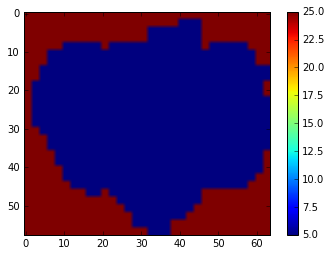

In [42]:
# testing whehter adding of new variable to PCR worked 
LDDtest = np.copy(hydrologicModel.get_var(('routing', 'lddMap')))
plt.figure()
plt.imshow(LDDtest)
plt.colorbar()

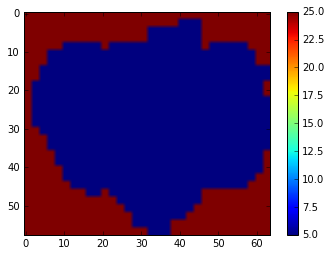

In [16]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [17]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

In [18]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               landmask_pcr)

In [19]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

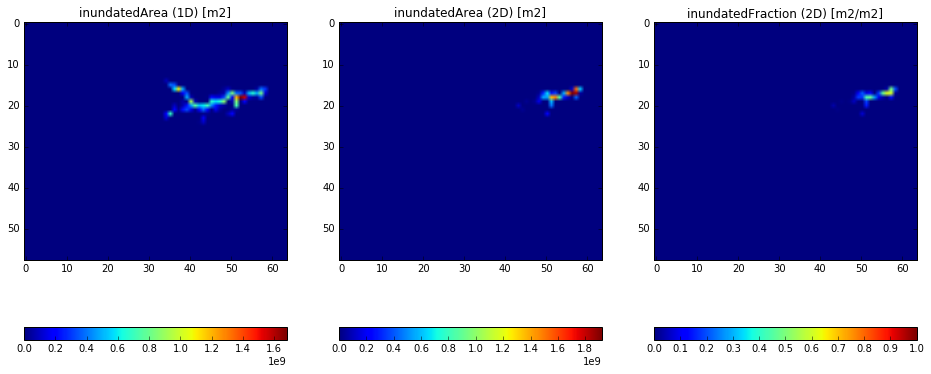

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [21]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells

In [22]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                       current_water_volume_1D,
                                                                                       couple_HLOG_2_HDYN,
                                                                                       coupled_HLOG_indices, 
                                                                                       landmask_pcr)

In [23]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

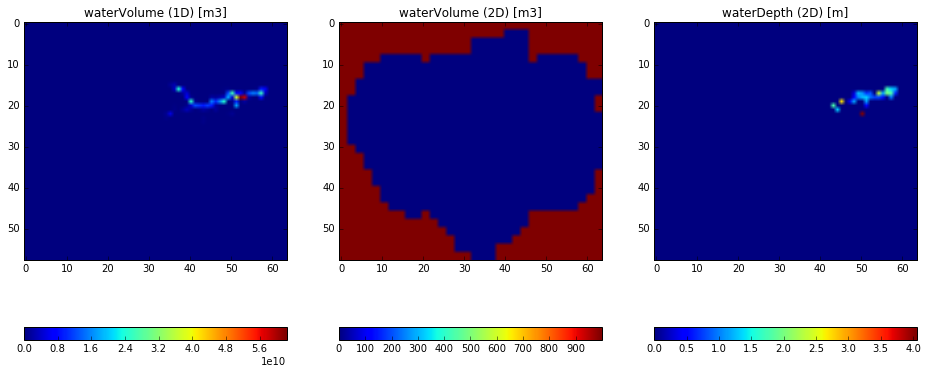

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [25]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

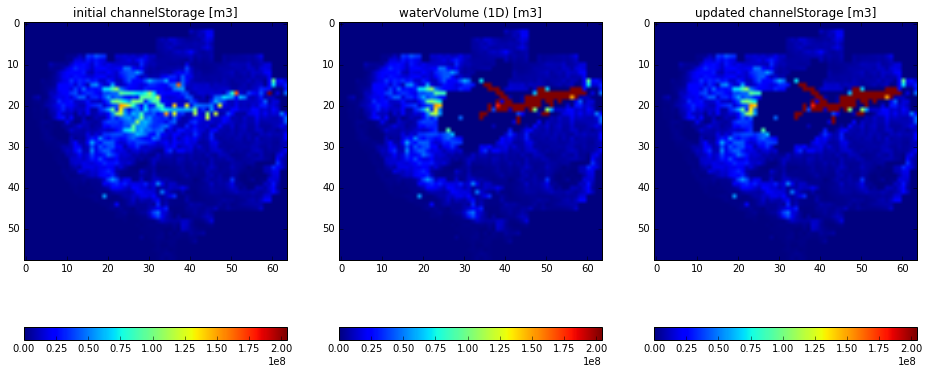

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [27]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.05598413266


In [28]:
hydrologicModel.update(1)

2018-02-20 11:08:23,926 model.pcrglobwb INFO Reading forcings for time 1984-01-01
2018-02-20 11:08:24,598 model.pcrglobwb INFO Updating model for time 1984-01-01
2018-02-20 11:08:24,825 model.landSurface INFO Updating land cover: forest
2018-02-20 11:08:24,828 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-20 11:08:25,038 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-20 11:08:25,242 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [30]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 3.71E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 3.71E+10
reduction by  0.0 %
delta volume for PCR cells coupled to hydrodynamic channels 2.23E+10


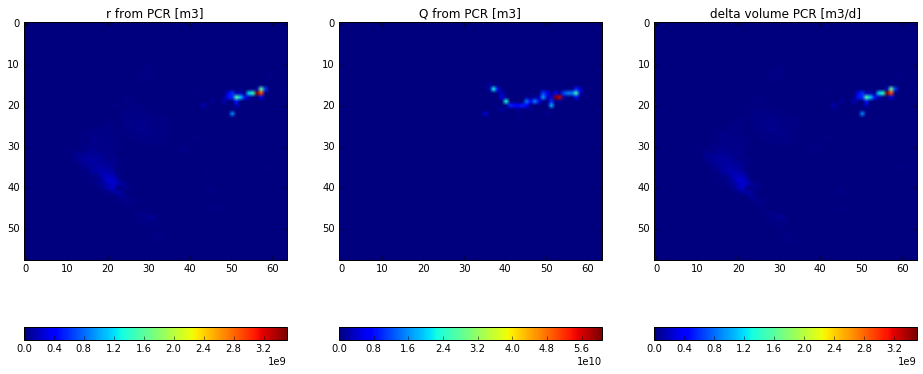

In [31]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [32]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [33]:
model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

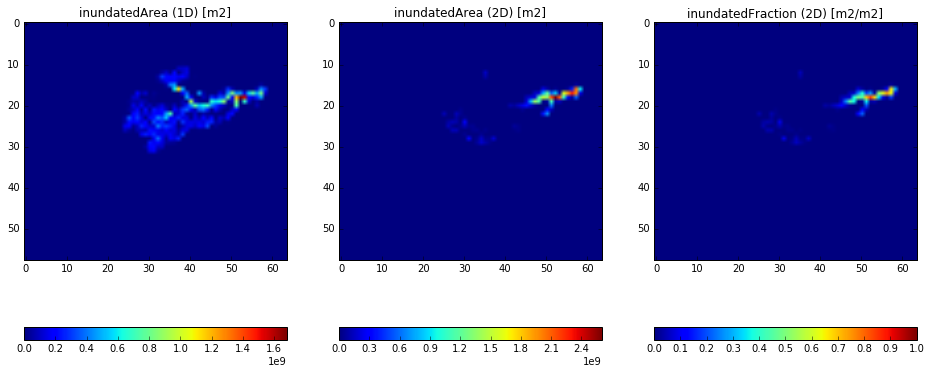

In [99]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

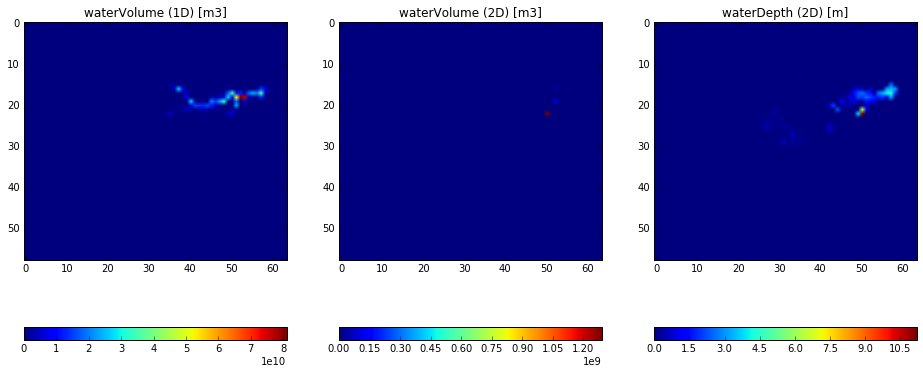

In [100]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
current_water_volume_1D = current_water_volume[separator_1D:]
current_water_volume_2D = current_water_volume[:separator_1D]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                       current_water_volume_1D,
                                                                                       couple_HLOG_2_HDYN,
                                                                                       coupled_HLOG_indices, 
                                                                                       landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

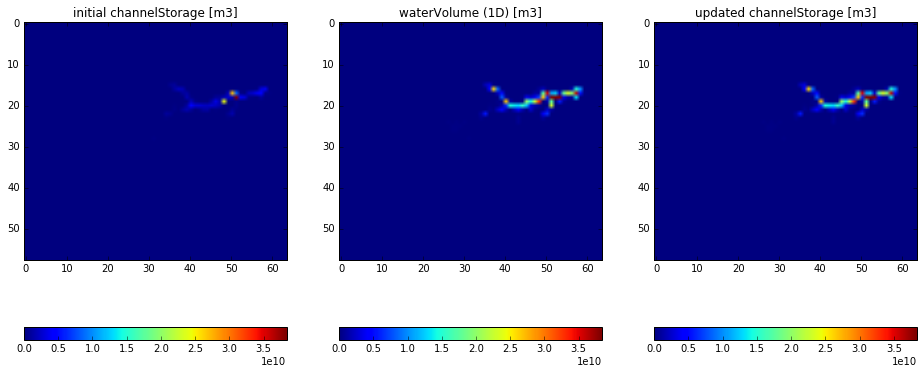

In [101]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [102]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 11.1963404014


In [103]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

2018-02-20 11:51:40,205 model.pcrglobwb INFO Reading forcings for time 1984-01-10
2018-02-20 11:51:42,997 model.pcrglobwb INFO Updating model for time 1984-01-10
2018-02-20 11:51:43,008 model.landSurface INFO Updating land cover: forest
2018-02-20 11:51:43,014 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 11:51:43,942 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-20 11:51:44,907 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: c

In [104]:
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 9.86E+10
feedback volume from FM: 1.48E+09 
delta volume of all PCR cells after feedback from DFM: 9.71E+10
reduction by  1.5 %
delta volume for PCR cells coupled to hydrodynamic channels 9.00E+10


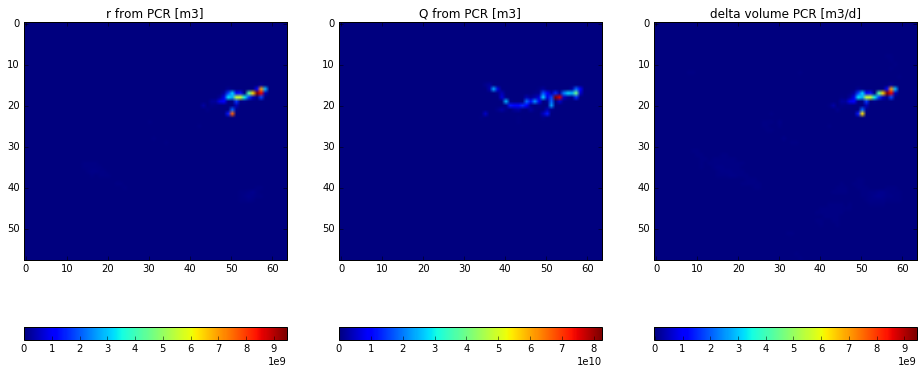

In [105]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [106]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)